# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
# !pip install datasets

In [1]:
import datasets # при работе локально

Импорт необходимых библиотек

In [417]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

import string
from IPython.display import display, clear_output
import pickle
import gc

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pzele\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

Found cached dataset imdb (C:/Users/pzele/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

### Посмотим на датасет

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [7]:
dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [8]:
sent_tokenize(dataset['train']['text'][1], language='english')

['"I Am Curious: Yellow" is a risible and pretentious steaming pile.',
 "It doesn't matter what one's political views are because this film can hardly be taken seriously on any level.",
 "As for the claim that frontal male nudity is an automatic NC-17, that isn't true.",
 "I've seen R-rated films with male nudity.",
 'Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia?',
 "Nowhere, because they don't exist.",
 'The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight.',
 "And those pretentious indie movies like The Brown Bunny, in which we're treated to the site of Vincent Gallo's throbbing johnson, but not a trace of pink visible on Chloe Sevigny.",
 'Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actress

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.

In [6]:
# Получить отдельные предложения и поместить их в sentences
sentences = []
word_threshold = 32

for paragraph in tqdm(dataset['train']['text']):
    
    # разбиваем параграф на предложения
    paragraph_to_sentences = sent_tokenize(paragraph, language='english')

    for sentence in paragraph_to_sentences:
        
        # понижаем все слова в предл и убираем пунктуацию
        preproc_sentence = sentence.lower().translate(str.maketrans('', '', string.punctuation))

        #добавляем только те предложения, длина слов в кот меньше word_threshold
        if len(word_tokenize(preproc_sentence)) < word_threshold:
            sentences.append(preproc_sentence)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
print("Всего предложений:", len(sentences))

Всего предложений: 219310


In [8]:
sentences[:10]

['i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in 1967',
 'really the sex and nudity scenes are few and far between even then its not shot like some cheaply made porno',
 'while my countrymen mind find it shocking in reality sex and nudity are a major staple in swedish cinema',
 'i am curiousyellow is a good film for anyone wanting to study the meat and potatoes no pun intended of swedish cinema',
 'but really this film doesnt have much of a plot',
 'i am curious yellow is a risible and pretentious steaming pile',
 'it doesnt matter what ones political views are because this film can hardly be taken seriously on any level',
 'as for the claim that frontal male nudity is an automatic nc17 that isnt true',
 'ive seen rrated films with male nudity',
 'granted they only offer some fleeting views but where are the rrated films with gaping vulvas and flapping labia']

Посчитаем для каждого слова его встречаемость.

In [7]:
# Расчет встречаемости слов
words = Counter()

for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1

  0%|          | 0/219310 [00:00<?, ?it/s]

In [8]:
# 10 самых встреч слов
words.most_common()[:10]

[('the', 185383),
 ('a', 91531),
 ('and', 89079),
 ('of', 77296),
 ('to', 73825),
 ('is', 66279),
 ('in', 50726),
 ('i', 50391),
 ('it', 49776),
 ('this', 49729)]

In [14]:
len(words)

82349

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
# Наполнение словаря
vocab = set()
vocab_size = 40000
for tpl in words.most_common():
    if len(vocab) < vocab_size:
        vocab.add(tpl[0])

vocab.update(set(['<unk>', '<bos>', '<eos>', '<pad>']))

In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [13]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [12]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [13]:
ind2word[1]

'dianne'

In [14]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []

      # в начало предл спец токен
        tokenized_sentence = [self.bos_id]
      
      # индексы из словаря ищем, если слова нет то спец токен УНК
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
      
      # конец предл токен
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [15]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [441]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [436]:
# для дебаггинга короткий sentence
short_sentences = sentences[:1000]

train_sentences, eval_sentences = train_test_split(short_sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(short_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [17]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            # Посчитайте логиты предсказаний следующих слов
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Арихтектура моделей

In [18]:
class LanguageModel(nn.Module):
    def __init__(self, rnn: str, hidden_dim: int, vocab_size: int, num_layers: int = 1):
        super().__init__()
        
        # иниц матр для эмб где будем их хранить
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # сама модель вариант 1
        if rnn == "RNN":
            self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif rnn == "GRU":
            self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif rnn == "LSTM":
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        
        # лин слой
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        
        # проекция на длину словаря, тк классификация по всему словарю
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]
        
        return projection

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [440]:
def train_model(model_names:list, hidden_dims: list, num_layers: list,
                optimizer_names:list, num_epoch, save_name):
    
    # определим количество строк для отображения графиков
    number_rows = len(model_names)*len(hidden_dims)*len(num_layers)*len(optimizer_names)
    
    # определим количество столбцов для отображения графиков
    number_columns = 2

    # позиция для отображения графика в таблице графиков
    position = 1

    # задаем размер фигуры для текущего подхода
    fig = plt.figure(figsize=(10, 7))
    
    # буду собирать данные после каждй эпохи в этот словарь
    all_experiments = {}

    # проходимся по всем моделям
    for model_name in model_names:
        # проходимся по всем размер скрыт слоя в rnn
        for hidden_dim in hidden_dims:
            # проходимся по всем кол-вам слоев в rnn
            for num_layer in num_layers:

                # модель
                model = LanguageModel(rnn = model_name,
                                      hidden_dim = hidden_dim,
                                      vocab_size = len(vocab),
                                      num_layers = num_layer
                                      ).to(device)
                
                # оптимизатор
                for optimizer_name in optimizer_names:
                    if optimizer_name == "Adadelta":
                        optimizer = torch.optim.Adadelta(model.parameters())
                    elif optimizer_name == "Adagrad":
                        optimizer = torch.optim.Adagrad(model.parameters())
                    elif optimizer_name == "Adam":
                        optimizer = torch.optim.Adam(model.parameters())

                    # лосс
                    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

                    # собираем лоссы и перплекс для текущего подхода: модель + hidden_dim + num_layer + optimizer_name + num_epoch
                    losses = []
                    perplexities = []
                    

                    # добавляю сабплоты на фигуру, для каждого подхода своя пара сабплотов
                    ax1 = fig.add_subplot(number_rows,number_columns,position)
                    ax2 = fig.add_subplot(number_rows,number_columns,position+1)

                    # проходимся по эпохам
                    for epoch in range(num_epoch):
                        
                        # временный словарь для сохранения данных о модели, лоссы и другие полезные данные
                        ddic={}

                        # лосс по батам
                        batch_losses = []

                        # train Режим
                        model.train()

                        # for batch in train_dataloader:
                        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
                            optimizer.zero_grad()
                            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
                            loss = criterion(logits, batch['target_ids'].flatten())
                            loss.backward()
                            optimizer.step()

                            # сохраняю текущие лоссы по каждому батчу
                            batch_losses.append(loss.item())

                        # добавляем лосс i-й эпохи
                        losses.append(sum(batch_losses) / len(batch_losses))

                        # добавляем перплексити для модели после i-й эпохи для eval выборки
                        perplexities.append(evaluate(model, criterion, eval_dataloader))

                        # Чтобы график оставался отображенным пока считается другая эпоха
                        clear_output(wait=True)
                        
                        # очистка сабплотов чтобы не было наслоения предыдущих отображений
                        ax1.clear()
                        ax2.clear()

                        # сами графики
                        ax1.plot(np.arange(len(losses)), losses,
                                 label=f'{model_name}_{hidden_dim}_{num_layer}_{optimizer_name}_{num_epoch}')
                        ax2.plot(np.arange(len(perplexities)), perplexities,
                                 label=f'{model_name}_{hidden_dim}_{num_layer}_{optimizer_name}_{num_epoch}')

                        # title для графиков
                        ax1.set_title('Loss')
                        ax2.set_title('Perplexity')

                        # легенда графиков
                        ax1.legend()
                        ax2.legend()

                        # отображение фигуры
                        display(fig)

                        # # пауза для отображения
                        # plt.pause(1)

                        # записываю во временный словарь данные об обучении в этой эпохе
                        ddic['epoch'] = epoch
                        ddic['model_state_dict'] = model.state_dict()
                        ddic['optimizer_state_dict'] = optimizer.state_dict()
                        ddic['losses'] = losses
                        ddic['perplexities'] = perplexities

                        # записываю временный словарь в глобальный словарь, который потом буду сохранять локально
                        all_experiments[f'{model_name}_{hidden_dim}_{num_layer}_{optimizer_name}_{num_epoch}'] = ddic

                        # сохраняю модель каждую эпоху
                        torch_save_path = 'C:/Users/pzele/Downloads/' + save_name + '.pt'
                        torch.save({
                                    'all_experiments': all_experiments,
                                    }, torch_save_path)

                    # сдвигаю позицию, чтобы отображать графики на следущей строчке
                    position += 2


### Что я буду менять в экспериментах

1. Модели: RNN, GRU, LSTM
2. Кол-во слоев rnn
3. Размеры скрыт сост у моделей

### Первый эксперимент (2 балла)


В первом эксперименте будут менять модели: RNN, GRU, LSTM

In [419]:
gc.collect()
torch.cuda.empty_cache()

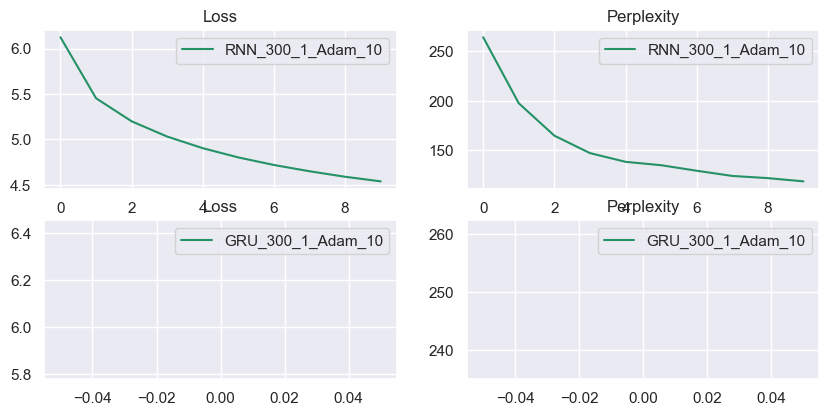

Training epoch 1::   0%|          | 0/1371 [00:00<?, ?it/s]

KeyboardInterrupt: 

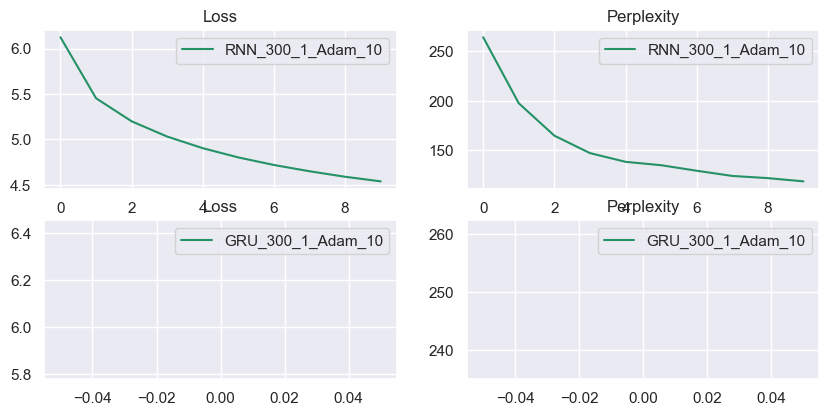

In [422]:
# Обучите модель здесь
train_model(model_names=['RNN'], hidden_dims=[300],
            num_layers=[1], optimizer_names=["Adam"],
            num_epoch=10, pkl_name="train_loop_models")

Дообучу GRU и LSTM тк пришлось прервать обучение, доработать код

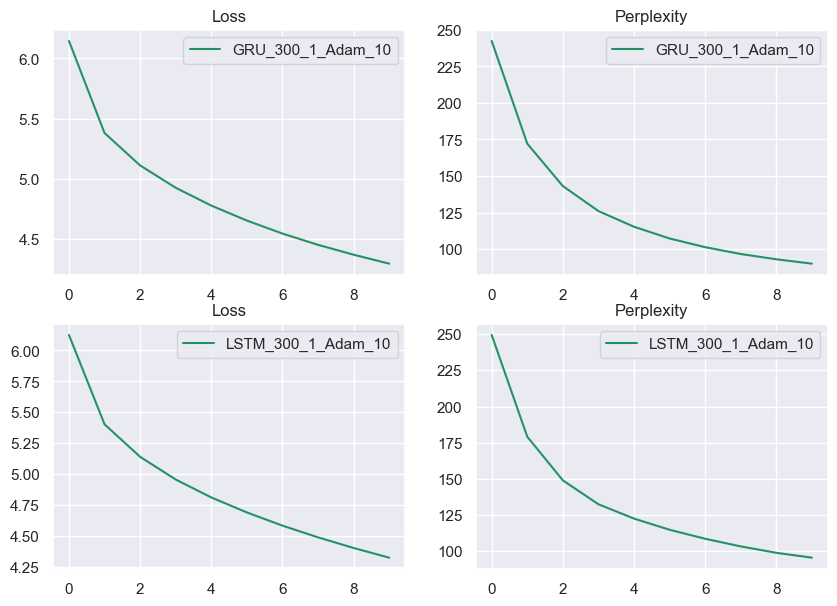

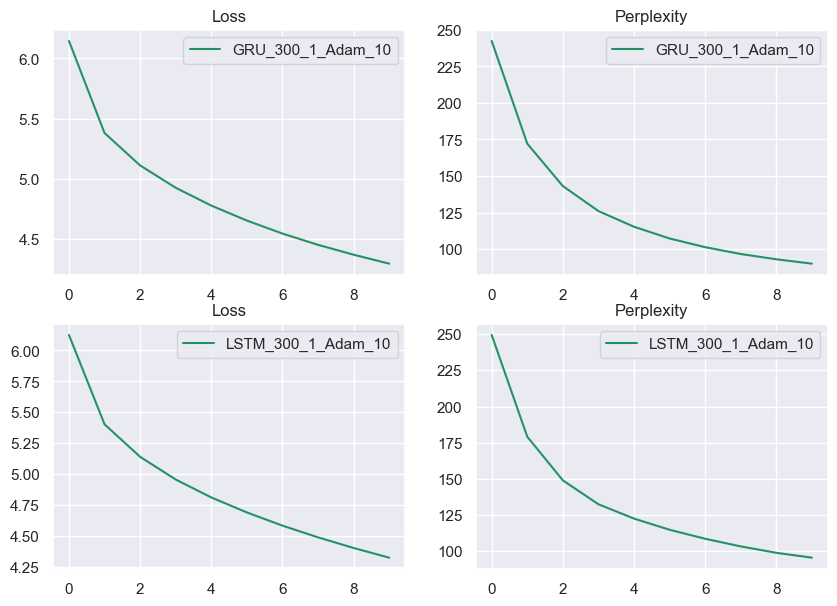

In [442]:
# Обучите модель здесь

gc.collect()
torch.cuda.empty_cache()


train_model(model_names=['GRU','LSTM'], hidden_dims=[300],
            num_layers=[1], optimizer_names=["Adam"],
            num_epoch=10, save_name="train_loop_models_1")

In [443]:
torch_load_path = 'C:/Users/pzele/Downloads/'+'train_loop_models_1'+'.pt'
tt = torch.load(torch_load_path)

In [444]:
tt

{'all_experiments': {'GRU_300_1_Adam_10': {'epoch': 9,
   'model_state_dict': OrderedDict([('embedding.weight',
                 tensor([[-1.5475,  1.8992, -0.1072,  ...,  0.4437,  0.7900, -1.2829],
                         [-0.1869,  0.0081, -0.4972,  ..., -0.0297,  1.3344, -1.8903],
                         [ 0.8714, -0.4346, -0.6230,  ..., -1.1356,  0.9713,  0.4262],
                         ...,
                         [ 0.4508,  0.2737, -0.7710,  ..., -0.0976, -0.0169, -1.6185],
                         [ 0.4588, -0.0200,  0.0831,  ..., -1.0779, -1.2518,  0.2779],
                         [ 0.7050, -0.8562, -0.5368,  ...,  1.3991, -1.7646, -0.2279]],
                        device='cuda:0')),
                ('rnn.weight_ih_l0',
                 tensor([[ 0.0080, -0.1535, -0.0175,  ...,  0.0647,  0.1593,  0.0037],
                         [-0.2060, -0.1292, -0.0678,  ..., -0.1020, -0.0058, -0.3272],
                         [ 0.0750,  0.1085,  0.0457,  ...,  0.1627, -0.1491, -0.0

In [446]:
pkl_name = 'C:/Users/pzele/Downloads/'+'train_loop_models'+'.pkl'
with open(pkl_name, "rb") as f:
    all_losses = pickle.load(f)
    all_perplexities = pickle.load(f)

### Результаты 1го эксперимента

Для чистоты эксперимента буду сравнивать только 5 эпох. Тк в последующих экспериментах для экономии времени обучал только на 5 эпохах

In [472]:
all_perplexities["RNN_300_1_Adam_10"][:5]

[263.9859893691999,
 197.34403432625734,
 164.64669675170472,
 147.05722562240192,
 138.24678003941005]

In [471]:
tt["all_experiments"]["GRU_300_1_Adam_10"]["perplexities"][:5]

[242.41600239596818,
 172.15578326266456,
 143.14656227138525,
 126.03509487655087,
 115.31087845543023]

In [470]:
tt["all_experiments"]["LSTM_300_1_Adam_10"]["perplexities"][:5]

[249.39331668956137,
 179.16165502986664,
 149.03136087103792,
 132.53338597229788,
 122.63711370692927]

In [475]:
print(f'Lowes perplexity for configuragion RNN_300_1_Adam_10 = {min(all_perplexities["RNN_300_1_Adam_10"][:5])}')
print(f'Lowes perplexity for configuragion GRU_300_1_Adam_10 = {min(tt["all_experiments"]["GRU_300_1_Adam_10"]["perplexities"][:5])}')
print(f'Lowes perplexity for configuragion LSTM_300_1_Adam_10 = {min(tt["all_experiments"]["LSTM_300_1_Adam_10"]["perplexities"][:5])}')

Lowes perplexity for configuragion RNN_300_1_Adam_10 = 138.24678003941005
Lowes perplexity for configuragion GRU_300_1_Adam_10 = 115.31087845543023
Lowes perplexity for configuragion LSTM_300_1_Adam_10 = 122.63711370692927


Видно что в этом эксперименте победила модель GRU_300_1_Adam_10. В следующем эксперименте применю GRU и попробую варьировать размер скрытого состояниях в rnn

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

В этом эксперименте оставлю модель GRU тк она показала себя лучше всего, попробую разные hidden dims = 200,300,400

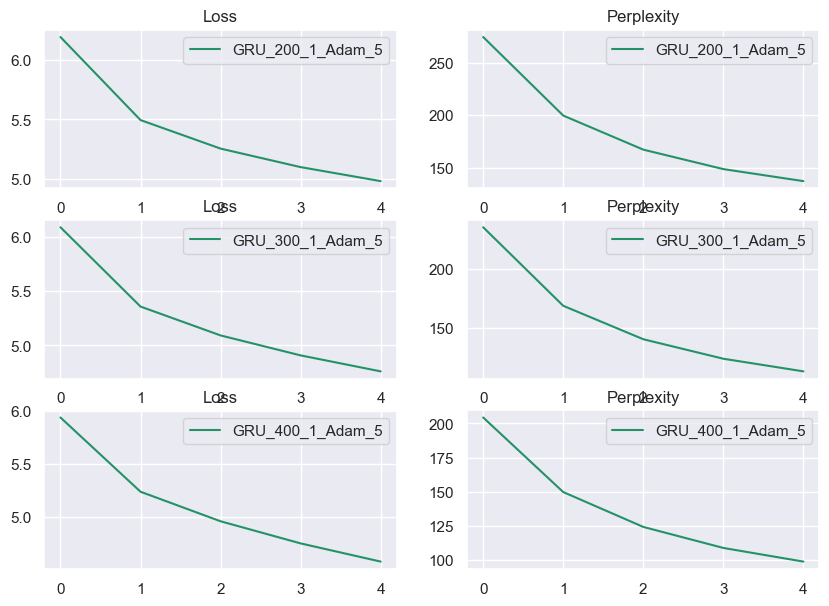

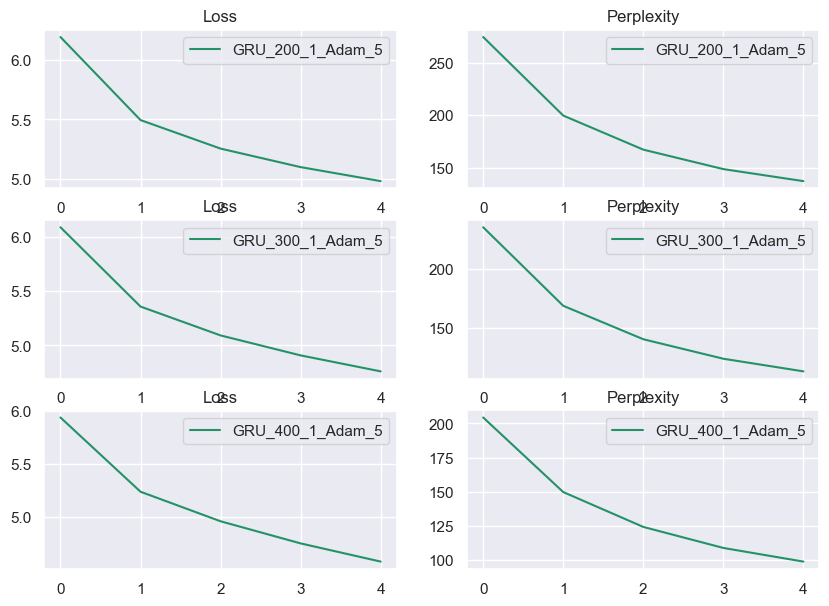

In [449]:
# Проведите второй эксперимент

gc.collect()
torch.cuda.empty_cache()

train_model(model_names=['GRU'], hidden_dims=[200,300,400],
            num_layers=[1], optimizer_names=["Adam"],
            num_epoch=5, save_name="train_loop_GRU_hidden_dims")

In [450]:
torch_load_path = 'C:/Users/pzele/Downloads/'+'train_loop_GRU_hidden_dims'+'.pt'
tt1 = torch.load(torch_load_path)

In [451]:
tt1

{'all_experiments': {'GRU_200_1_Adam_5': {'epoch': 4,
   'model_state_dict': OrderedDict([('embedding.weight',
                 tensor([[-1.0714, -0.8598,  0.4051,  ...,  1.2560, -0.2519, -0.6947],
                         [ 0.0147,  1.9187, -1.8336,  ..., -1.4065,  0.5649, -2.0238],
                         [-0.5450,  0.8506,  0.0982,  ..., -1.8794, -0.1462,  0.2596],
                         ...,
                         [ 0.5815,  1.0609, -0.9252,  ..., -0.4415,  0.7710,  1.1571],
                         [ 0.4178, -1.2797,  0.0285,  ..., -0.8428,  0.1055,  1.0059],
                         [ 0.3494, -1.0425, -0.9816,  ..., -1.7921, -0.1809,  0.1656]],
                        device='cuda:0')),
                ('rnn.weight_ih_l0',
                 tensor([[-0.0121, -0.1386,  0.1331,  ...,  0.0302,  0.0224, -0.1489],
                         [ 0.0580, -0.2267,  0.0377,  ...,  0.1615,  0.0301,  0.1258],
                         [-0.0023, -0.0765, -0.0507,  ..., -0.0958, -0.1842, -0.08

### Результаты 2го эксперимента

In [476]:
tt1["all_experiments"]["GRU_200_1_Adam_5"]["perplexities"][:5]

[274.3123496021106,
 199.57104547382653,
 167.15958404541016,
 148.6497970990567,
 137.212459283782]

In [477]:
tt1["all_experiments"]["GRU_300_1_Adam_5"]["perplexities"][:5]

[235.467332713106,
 169.0268066210396,
 140.7425946799849,
 124.25462381369591,
 113.57676084289194]

In [478]:
tt1["all_experiments"]["GRU_400_1_Adam_5"]["perplexities"][:5]

[204.40348137551734,
 149.6220074879525,
 124.01200644138117,
 108.57129880177376,
 98.54241500907906]

In [479]:
print(f'Lowes perplexity for configuragion GRU_200_1_Adam_5 = {min(tt1["all_experiments"]["GRU_200_1_Adam_5"]["perplexities"][:5])}')
print(f'Lowes perplexity for configuragion GRU_300_1_Adam_5 = {min(tt1["all_experiments"]["GRU_300_1_Adam_5"]["perplexities"][:5])}')
print(f'Lowes perplexity for configuragion GRU_400_1_Adam_5 = {min(tt1["all_experiments"]["GRU_400_1_Adam_5"]["perplexities"][:5])}')

Lowes perplexity for configuragion GRU_200_1_Adam_5 = 137.212459283782
Lowes perplexity for configuragion GRU_300_1_Adam_5 = 113.57676084289194
Lowes perplexity for configuragion GRU_400_1_Adam_5 = 98.54241500907906


Видно что в этом эксперименте победила модель GRU_400_1_Adam_5. Чем больше размер скрытого состояния в rnn, тем выше качество. С этими параметрами попробую поиграть с количеством слоев rnn.

### Третий эксперимент

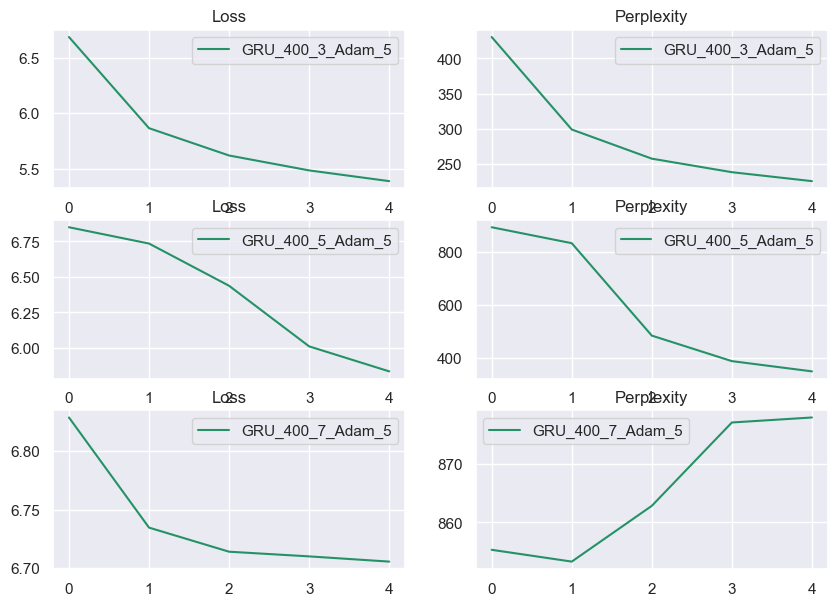

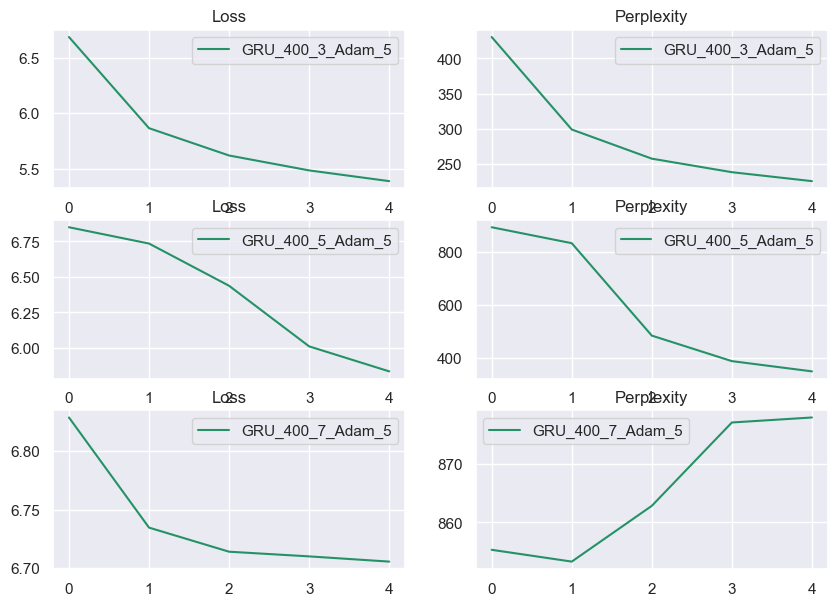

In [452]:
gc.collect()
torch.cuda.empty_cache()

train_model(model_names=['GRU'], hidden_dims=[400],
            num_layers=[3,5,7], optimizer_names=["Adam"],
            num_epoch=5, save_name="train_loop_GRU_num_layers")

In [453]:
torch_load_path = 'C:/Users/pzele/Downloads/'+'train_loop_GRU_num_layers'+'.pt'
tt2 = torch.load(torch_load_path)

In [454]:
tt2

{'all_experiments': {'GRU_400_3_Adam_5': {'epoch': 4,
   'model_state_dict': OrderedDict([('embedding.weight',
                 tensor([[-0.1271,  0.7706,  1.7600,  ...,  0.0721, -1.6471, -2.4855],
                         [-0.3987, -1.7097,  0.8992,  ...,  0.0132,  1.9921, -1.6757],
                         [ 0.5863, -0.0469,  0.4894,  ..., -0.8251,  0.0357,  0.1294],
                         ...,
                         [-1.8373,  0.2503,  0.2505,  ...,  0.3253, -1.4538,  0.3570],
                         [ 1.1194, -0.2613, -0.3391,  ..., -0.0504,  0.2249,  0.1360],
                         [ 0.0566,  0.8829, -1.2241,  ..., -1.1703, -2.0751, -0.8565]],
                        device='cuda:0')),
                ('rnn.weight_ih_l0',
                 tensor([[ 0.1683,  0.1990, -0.0149,  ...,  0.0545,  0.1252, -0.0183],
                         [ 0.1255,  0.0604, -0.2492,  ..., -0.0739,  0.0871,  0.1062],
                         [-0.0585,  0.1183,  0.1368,  ..., -0.0447,  0.0354, -0.00

### Результаты 3го эксперимента

In [480]:
tt2["all_experiments"]["GRU_400_3_Adam_5"]["perplexities"][:5]

[430.567667833148,
 298.8895704877001,
 257.3994377786109,
 238.1372964830076,
 225.42085214479107]

In [481]:
tt2["all_experiments"]["GRU_400_5_Adam_5"]["perplexities"][:5]

[895.2563201655029,
 834.7878956388565,
 484.4726160821725,
 387.79195169918455,
 349.0004577636719]

In [482]:
tt2["all_experiments"]["GRU_400_7_Adam_5"]["perplexities"][:5]

[855.3089088965186,
 853.290474071525,
 862.8336465806639,
 877.1019849743838,
 877.9586895972734]

In [484]:
print(f'Lowes perplexity for configuragion GRU_400_3_Adam_5 = {min(tt2["all_experiments"]["GRU_400_3_Adam_5"]["perplexities"][:5])}')
print(f'Lowes perplexity for configuragion GRU_400_5_Adam_5 = {min(tt2["all_experiments"]["GRU_400_5_Adam_5"]["perplexities"][:5])}')
print(f'Lowes perplexity for configuragion GRU_400_7_Adam_5 = {min(tt2["all_experiments"]["GRU_400_7_Adam_5"]["perplexities"][:5])}')

Lowes perplexity for configuragion GRU_400_3_Adam_5 = 225.42085214479107
Lowes perplexity for configuragion GRU_400_5_Adam_5 = 349.0004577636719
Lowes perplexity for configuragion GRU_400_7_Adam_5 = 853.290474071525


Видно что в этом эксперименте победила модель GRU_400_3_Adam_5. Но тут пепрлексия значительно больше нежели чем с одним слоем как в предыдущем эксперименте. Так же видно, что чем больше слоев rnn тем хуже качество.

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [485]:
print(f'Lowes perplexity for configuragion RNN_300_1_Adam_10 = {min(all_perplexities["RNN_300_1_Adam_10"][:5])}')
print(f'Lowes perplexity for configuragion GRU_300_1_Adam_10 = {min(tt["all_experiments"]["GRU_300_1_Adam_10"]["perplexities"][:5])}')
print(f'Lowes perplexity for configuragion LSTM_300_1_Adam_10 = {min(tt["all_experiments"]["LSTM_300_1_Adam_10"]["perplexities"][:5])}')
print(f'Lowes perplexity for configuragion GRU_200_1_Adam_5 = {min(tt1["all_experiments"]["GRU_200_1_Adam_5"]["perplexities"][:5])}')
print(f'Lowes perplexity for configuragion GRU_300_1_Adam_5 = {min(tt1["all_experiments"]["GRU_300_1_Adam_5"]["perplexities"][:5])}')
print(f'Lowes perplexity for configuragion GRU_400_1_Adam_5 = {min(tt1["all_experiments"]["GRU_400_1_Adam_5"]["perplexities"][:5])}')
print(f'Lowes perplexity for configuragion GRU_400_3_Adam_5 = {min(tt2["all_experiments"]["GRU_400_3_Adam_5"]["perplexities"][:5])}')
print(f'Lowes perplexity for configuragion GRU_400_5_Adam_5 = {min(tt2["all_experiments"]["GRU_400_5_Adam_5"]["perplexities"][:5])}')
print(f'Lowes perplexity for configuragion GRU_400_7_Adam_5 = {min(tt2["all_experiments"]["GRU_400_7_Adam_5"]["perplexities"][:5])}')

Lowes perplexity for configuragion RNN_300_1_Adam_10 = 138.24678003941005
Lowes perplexity for configuragion GRU_300_1_Adam_10 = 115.31087845543023
Lowes perplexity for configuragion LSTM_300_1_Adam_10 = 122.63711370692927
Lowes perplexity for configuragion GRU_200_1_Adam_5 = 137.212459283782
Lowes perplexity for configuragion GRU_300_1_Adam_5 = 113.57676084289194
Lowes perplexity for configuragion GRU_400_1_Adam_5 = 98.54241500907906
Lowes perplexity for configuragion GRU_400_3_Adam_5 = 225.42085214479107
Lowes perplexity for configuragion GRU_400_5_Adam_5 = 349.0004577636719
Lowes perplexity for configuragion GRU_400_7_Adam_5 = 853.290474071525


#### Выводы по работе

В учебных целях, я обучал модели на 5 эпохах ради экономии времени.  В среднем 5 эпох это примерно чуть меньше 20 минут.

1. В самом начале я выставил параметры:
    Скрытое состояние = 300
    Количество слоев rnn = 1
    Оптимизатор = Адам

    На этих параметрах я тренировал 3 модели - RNN, GRU, LSTM. На 5й эпохе лучшую перплексию показала модель GRU, GRU_300_1_Adam_10 = 115.31087845543023

2. Потом я взял GRU и стал менять размер скрытого состояния у модели - 200,300,400. Получилось что перплексия обновила минимум с предыдущего раза и стала еще лучше при размере скрытого сост = 400. GRU_400_1_Adam_5 = 98.54241500907906

3. В последнем эксперименте я взял конфигурацию выше, GRU + hidden state =400 и стал добавлять слоев - 3,5,7 слоев.
    Результаты стали только хуже, самая низкая перплексия здесь это GRU_400_3_Adam_5 = 225.42085214479107, а самаяа высокая GRU_400_7_Adam_5 = 853.290474071525. По графику после этого эксперимента видно, что с 7ми слоями перплексия не только не опускалась, но и начала расти.

В итоге лучшая настройка эксперимента оказалась с параметрами:
    Модель = GRU
    Скрытое состояние = 400
    Количество слоев rnn = 1

GRU_400_1_Adam_5 = 98.54241500907906

Основные выводы:
1. Чем больше слоев rnn тем хуже
2. Чем больше размер скрытого состояния rnn, тем лучше

#### Что можно улучшить?

Я еще хотел попробовать 3 вида оптимизатора (Adam,Adagrad, Adadelta) сравнить между собой, но уже времени не остается совсем. После этого как выявится победитель уже поиграть с настройками этого оптимизатора (шаг шаг обучение и тп). Так же добавить sheduler чтобы попробовать прийти к еще более низкому лоссу и тем самым низкой перплексии.





